# Prediction of olfactory receptor (OR) basal activities

This notebook trains `Random Forest` regression models to predict the *in vitro* basal activity of human, mouse and some primate ORs.   
This is done in four steps:  
1. load & transform training data;
2. train 4 independent models with 4 subsets of residues, and compare their predictivity with a non-predictive control model;
3. build a final model with the best residue subset above, then predict the basal activity of new ORs that belong to the **Applicability Domain** of the model;
4. evaluate the prediction with *in vitro* measurements.


## Software requirements

- `R` version 3.5 or higher is recommended.  
- Required R packages: `caret`, `MLmetrics`, `e1071`, `bio3d`, `stringr`, `ggpubr`, `gplots`, `gridExtra`  
It is recommended to install the packages with `Conda` (e.g. `conda install r-MLmetrics`, `conda install -c conda-forge r-ggpubr`) prior to using this notebook.  
Alternative package installtion by `install.packages` (see below) may **fail**.  

### Install & load required packages

In [17]:
packages <- c("caret", "ROCR", "MLmetrics", "e1071", "bio3d", "stringr", "gplots", "ggpubr", "gridExtra")
missing <- !unlist(lapply(packages, require, character.only = TRUE))

if (any(missing)){
    install.packages(packages[missing], dependencies = TRUE, repos='http://cran.us.r-project.org')
    lapply((packages[missing]), library, character.only = TRUE)
    }

## 1. Training data  
- **Basal activity data** of 176 ORs measured *in vitro*. 
- **OR sequences**: pre-aligned sequences of the ORs, in which each amino acid will be converted to three physicochemical scores (`Composition`, `Polarity`, `Volumn`);  

### 1.1 Basal activity data
Read the basal activities of 176 ORs measured *in vitro* and examine the data distribution.

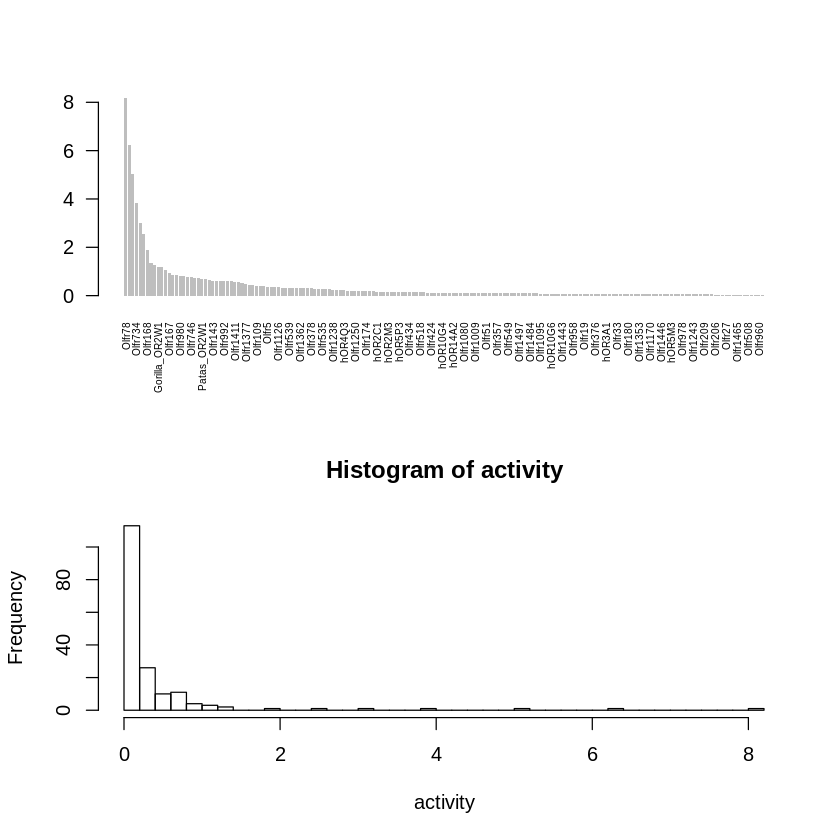

In [2]:
basal <- read.csv("Basal_activity/Data/Training_set.csv", stringsAsFactors = FALSE)

# Plot the mean values of the basal activity
activity <- basal$Mean
names(activity) <- basal$Gene

par(mfrow=c(2,1))
barplot(activity, las=2, cex.names = 0.5, border = NA)
hist(activity, breaks = 50)

#### Because of the highly skewed distribution of the data, we apply a log transformation to obtain a near normal distribution

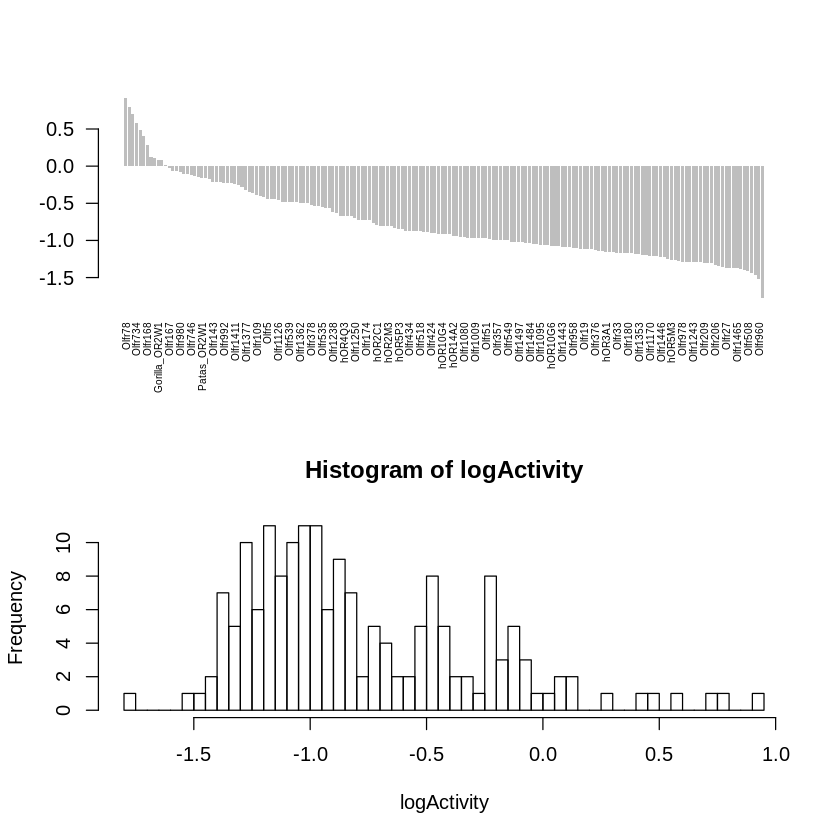

In [3]:
logActivity <- log10(basal$Mean)
names(logActivity) <- basal$Gene

# Plot the data distribution after log transformation
par(mfrow=c(2,1))
barplot(logActivity, las=2, cex.names = 0.5, border = NA)
hist(logActivity, breaks = 50)

### 1.2 Convert OR sequence alignment to physicochemical features

Read the OR sequence alignment, including some mutants. For this study, only the 7-transmembrane domain (7TM) and the extracellular loop 2 (ECL2) are included in the alignment, which are numbered according to the prototypical mouse OR 256-8 (*mOR256-8*, gene name [Olfr1362](https://www.uniprot.org/uniprot/Q5SZZ8)). 

In [4]:
# Read the OR sequence alignment 
seq <- read.fasta("Basal_activity/Data/Sequence_alignment.fa")

# Extract training set ORs
datOR <- as.data.frame(seq$ali)

# Residue numbers of mouse OR 256-8
TM_ECL2 <- c(24:57,            # TM1 
             59:87,            # TM2
             97:127,           # TM3
             139:160,          # TM4
             161:169, 175:188, # part of ECL2
             197:225,          # TM5
             236:260,          # TM6
             272:292)          # TM7 

colnames(datOR) <- paste0("Res", TM_ECL2)

#### Take a look at the first 5 residues of 3 ORs:

In [5]:
datOR[1:3, 1:5]

,Res24,Res25,Res26,Res27,Res28
hOR10G3,R,T,L,F,F
hOR10G4,D,A,L,L,F
hOR10G6,G,A,P,L,F


Remove gaps from the alignment, then convert each amimo acid to its physicochemical scores (features): `Composition`, `Polarity`, `Volumn` [Grantham, Science (1974) 185:862-4](https://science.sciencemag.org/content/185/4154/862)

In [6]:
# Remove columns that contain gaps in > 0.5% of the ORs 
datOR <- datOR[, colSums(datOR == "-") < nrow(datOR)*0.005]

# Remove ORs theat still contain gaps
datOR <- datOR[rowSums(datOR == "-") == 0, ]

# Convert amino acids to physicochemical features
source("Functions/sequence2features_Grantham1974.R")
datOR <- cbind(residProps(datOR, "Vol"),
               residProps(datOR, "Comp"),
               residProps(datOR, "Polar"))

# Remove low variance features
near_zero <- nearZeroVar(datOR, freqCut = 95/5, saveMetrics = TRUE)
low_variance_cols <- near_zero[(near_zero$zeroVar == TRUE) | (near_zero$nzv == TRUE), ]
drops <- rownames(low_variance_cols)
datOR <- datOR[, !(names(datOR) %in% drops)]

# Remove highly correlated features
correlationMatrix <- cor(datOR)
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff=0.85)
datOR <- datOR[, -highlyCorrelated]

# Extract training set ORs
trainORs <- datOR[rownames(datOR) %in% basal$Gene, ]

## 2. Model training
Train 4 independent models, starting from 4 heuristic subsets of residues in the OR sequences:

- ***res49***, 49 residues surrounding the conserved motifs  
- ***res68***, *res49* + 19 residues that had **major** impact on the basal activity of mOR256-8 upon mutation  
- ***res77***, *res68* + 9 residues that had **moderate** impact on the basal activity of mOR256-8 upon mutation  
- ***TM191***, 191 residues in the transmembrane (TM) domain  

As control, a non-predictive model will be built with pseudo-sequences of 68 random residues.

In [7]:
subsets <- c("res49", "res68", "res77", "TM191", "random")

# Residue numbers in mOR256-8 
res49 <- c(34, 37:40, 43:46, 48, 49, 52:54,                  # TM1
           71:74,                                            # TM2
           107, 110, 111, 114:117,                           # TM3
           141, 145, 149,                                    # TM4
           205, 207, 208, 211, 213:216, 221, 222, 224, 225,  # TM5
           245:248, 251,                                     # TM6
           279:282)                                          # TM7

major <- c(99, 102, 106, 108, 110, 120, 123,  # TM3
           140, 151, 156:158,                 # TM4
           181,                               # ECL2
           200,                               # TM5
           239, 252, 254, 255, 257, 260)      # TM6

moderate <- c(103,                 # TM3
              143, 146, 148, 159,  # TM4
              175,                 # ECL2
              199, 203, 204)       # TM5

res68 <- unique(c(res49, major))

res77 <- unique(c(res49, major, moderate))

TM191 <- c(24:57,   # TM1
           59:87,   # TM2
           97:127,  # TM3
           139:160, # TM4
           197:225, # TM5
           236:260, # TM6
           272:292) # TM7

# for the non-predictive control model
random <- sample(TM_ECL2, 68)

## 2.1 Applicability domain & 5-fold cross validation
- We will use **half** of the training set ORs which have higher sequence similarities than the rest, because the available data are insufficient to address the high sequence diversity in the whole training set.  
- A matrix of pairwise Euclidean distance between the OR sequences (as a metric of similarity) is calculated to rank and select the ORs.  
- Using each residue subset and the selected ORs, `Random Forest` regression models are trained and evaluated by a 5-fold cross validation. 

In [8]:
numextract <- function(string){
    as.numeric(str_extract(string, "\\-*\\d+\\.*\\d*"))
}
# Loop over the residue subsets
for (subset in subsets){
    # Extract the subset residues
    trainData <- trainORs[, numextract(colnames(trainORs)) %in% get(subset)]
    
    # Calculate a matrix of Euclidean distances
    matEuc <- as.matrix(dist(trainData))
    
    # Seletct half the ORs  
    cutoff <- median(colMeans(matEuc))
    trainData <- trainData[colMeans(matEuc) < cutoff, ]

    # Remove low variance features
    near_zero <- nearZeroVar(trainData, freqCut = 95/5, saveMetrics = TRUE)
    low_variance_cols <- near_zero[(near_zero$zeroVar == TRUE) | (near_zero$nzv == TRUE), ]
    drops <- rownames(low_variance_cols)
    trainData <- trainData[, !(names(trainData) %in% drops)]

    # Add activity data
    trainData$Activity <- logActivity[rownames(trainData)]
    
    # for the control model, generate pseudo-sequences by randomizing the residues and the activities
    if (subset == "random"){
        pseudoSeq <- trainData[sample(nrow(trainData)), sample(ncol(trainData) - 1)]
        trainData <- cbind(pseudoSeq, Activity = sample(trainData$Activity))
    } 
    
    # Stratify into 5 folds for cross validation
    folds <- createFolds(trainData$Activity, 5, list = TRUE)
  
    # An empty matrix to summarize the metrics of model performance
    metrics <- c("RMSE", "R2", "MAE")
    perfSum <- matrix(nrow = 5, ncol = length(metrics))
    rownames(perfSum) <- paste("Fold", 1:5, sep="_")
    colnames(perfSum) <- metrics
    
    # 5-fold cross validaton
    for (i in 1:5){
        # Split training & validation sets
        trainingSet <- trainData[-unlist(folds[i]), ]
        valSet <- trainData[unlist(folds[i]), ]
        
        # Center & scale data
        preProc <- preProcess(trainingSet, method = c("center", "scale"))
        trainingProc <- predict(preProc, trainingSet)
        valProc <- predict(preProc, valSet)
        
        # Parameter tuning using nested 5-fold cross validation
        control <- trainControl(method="cv",
                                number=5,
                                summaryFunction = defaultSummary)
        grid <- expand.grid(.mtry = seq(ncol(trainingProc)/2, ncol(trainingProc)-1, length.out= 5))
        
        # Train a random forest regression model with the tuned parameters
        mod_RF <- train(data = trainingProc,
                         Activity ~ . , 
                         trControl = control,
                         method = "rf", 
                         tuneGrid = grid,
                         ntree = 1001,
                         metric = 'Rsquared')
        
        # Use the model to predicte the basal activities of the validation set ORs
        pred <- predict(mod_RF, newdata = valProc)
        perfSum[i, ] <- round(postResample(pred, valProc$Activity), 2)
    }
    
    # Mean, SD & SEM of the performance summary
    perfSum <- rbind(perfSum, Mean = round(colMeans(perfSum), 2), SD =round(apply(perfSum, 2, sd), 2))
    perfSum <- rbind(perfSum, SEM = round(perfSum['SD', ]/sqrt(5), 2))
    cat("\nPerformance summary of model", subset, "\n")
    print(perfSum)
    
    # Output to file
    write.table(perfSum, paste0("Basal_activity/Cross_validation/", subset, ".tsv"), sep = "\t", quote = FALSE)
}


Performance summary of model res49 
       RMSE   R2  MAE
Fold_1 0.68 0.64 0.52
Fold_2 0.75 0.40 0.57
Fold_3 0.68 0.48 0.49
Fold_4 0.60 0.56 0.42
Fold_5 0.89 0.41 0.74
Mean   0.72 0.50 0.55
SD     0.11 0.10 0.12
SEM    0.05 0.04 0.05

Performance summary of model res68 
       RMSE   R2  MAE
Fold_1 0.50 0.64 0.38
Fold_2 0.80 0.60 0.60
Fold_3 0.85 0.31 0.64
Fold_4 0.57 0.75 0.43
Fold_5 0.59 0.65 0.48
Mean   0.66 0.59 0.51
SD     0.15 0.17 0.11
SEM    0.07 0.08 0.05

Performance summary of model res77 
       RMSE   R2  MAE
Fold_1 0.93 0.23 0.73
Fold_2 0.70 0.66 0.47
Fold_3 0.44 0.79 0.34
Fold_4 0.67 0.49 0.56
Fold_5 0.65 0.56 0.52
Mean   0.68 0.55 0.52
SD     0.17 0.21 0.14
SEM    0.08 0.09 0.06

Performance summary of model TM191 
       RMSE   R2  MAE
Fold_1 0.94 0.46 0.74
Fold_2 0.80 0.31 0.57
Fold_3 0.83 0.24 0.64
Fold_4 0.58 0.73 0.45
Fold_5 0.69 0.50 0.59
Mean   0.77 0.45 0.60
SD     0.14 0.19 0.11
SEM    0.06 0.08 0.05

Performance summary of model random 
       RMSE   R2  MAE


## 2.2 Visualize model performances
### Compare the performance of the 4 models with the non-predictive control model (*random*).  

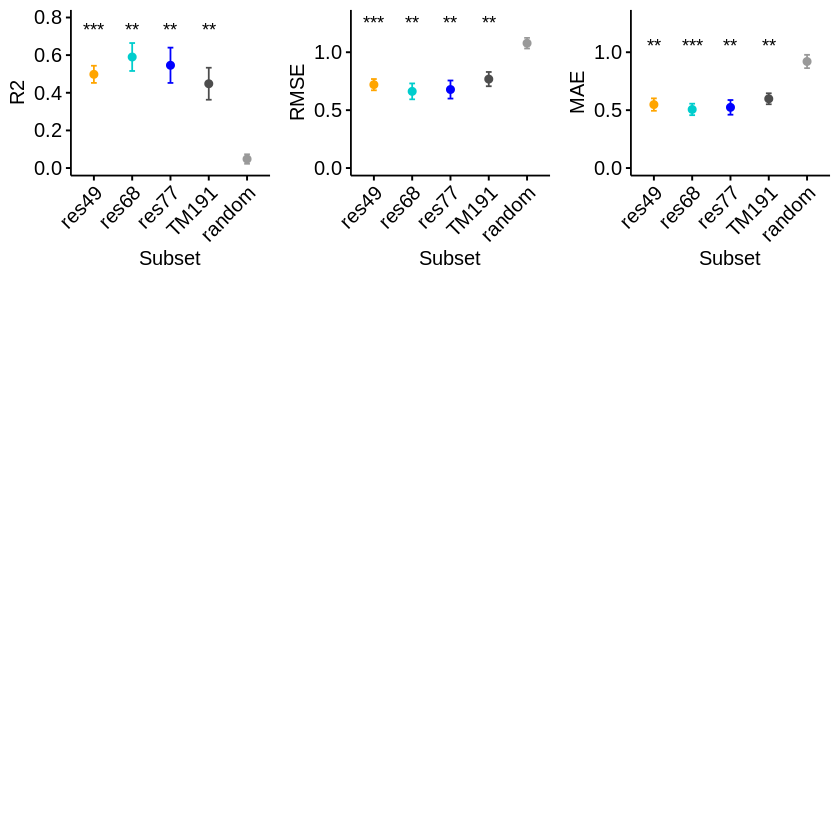

In [9]:
# Summarize the performance of all the models in a data frame
dat <- data.frame()
for (i in 1:length(subsets)){
    perf <- read.table(paste0("Basal_activity/Cross_validation/", subsets[i], ".tsv"), sep = "\t", row.names = 1)
    perf <- subset(perf[1:5, ], select = metrics)
    dat <- rbind(dat, merge(subsets[i], perf))
}
names(dat) <- c("Subset", metrics)

col_palette <- c('orange', 'cyan3', 'blue', 'gray30', 'gray60')

# Plot the R-squared
p_R2 <- ggerrorplot(dat, x = "Subset", y = "R2", 
                         color = "Subset", palette = col_palette,
                         add = "mean", add.params = list(size = 0.3),
                         error.plot = "errorbar", width = 0.5, legend = "none") + 
coord_cartesian(ylim = c(0, 0.8)) + rotate_x_text(45) +
# Statistical comparison with the control model
stat_compare_means(label = "p.signif", label.y = 0.7, method = "t.test", ref.group = "random")

# Plot the RMSE
p_RMSE <- ggerrorplot(dat, x = "Subset", y = "RMSE", color = "Subset", palette = col_palette,
                     add = "mean", add.params = list(size = 0.3),
                     error.plot = "errorbar", width = 0.5, legend = "none") + 
coord_cartesian(ylim = c(0, 1.3)) + rotate_x_text(45) +
stat_compare_means(label = "p.signif", label.y = 1.2, method = "t.test", ref.group = "random")

# Plot the MAE
p_MAE <- ggerrorplot(dat, x = "Subset", y = "MAE", 
                         color = "Subset", palette = col_palette,
                         add = "mean", add.params = list(size = 0.3),
                         error.plot = "errorbar", width = 0.5, legend = "none") + 
coord_cartesian(ylim = c(0, 1.3)) + rotate_x_text(45) +
# Statistical comparison with the control model
stat_compare_means(label = "p.signif", label.y = 1, method = "t.test", ref.group = "random")

grid.arrange(p_R2, p_RMSE, p_MAE, ncol = 3, heights = c(1, 2))

### Evaluation:
All the 4 models performed significantly better than the control (random), however, the differences among them are not statistically significant.
We choose the model ***res68***, which performed the best on average.

## 3. Predict the basal activity of new ORs
- Rebuild the best model above (***res68***), with all the training data (without splitting into training & validation sets).
- Selet test ORs that belong to the **applicability domain** of the model (according to their Euclidean distances to the training set).  
- Predict the basal activities of the test set and compare with the *in vitro* measurements.  

In [10]:
# Rebuilt the res68 model
subset <- "res68"

# Extract the subset residues
trainData <- trainORs[, numextract(colnames(trainORs)) %in% get(subset)]

# Calculate pairwise Euclidean distance matrix between the training ORs
matTrain <- as.matrix(dist(trainData))

# Extract test set ORs
testORs <- readLines("Basal_activity/Data/Query_ORs.txt")
testData <- datOR[rownames(datOR) %in% testORs, colnames(datOR) %in% colnames(trainData)]

# Calculate pairwise Euclidean distance matrix between the training and the test ORs
matTest <- as.matrix(dist(rbind(trainData, testData)))
matTest <- matTest[1:nrow(matTrain), -(1:ncol(matTrain))]

# Normalize the two matrices
norm01 <- function(x, a, b){(x - min(c(a, b)))/(max(c(a,b)) - min(c(a, b)))}
matTrain <- norm01(matTrain, matTrain, matTest)
matTest <- norm01(matTest, matTrain, matTest)

# Order rows & columns
matTrain <- matTrain[order(rowMeans(matTrain)), order(colMeans(matTrain))]
matTest <- matTest[rownames(matTrain), order(colMeans(matTest))]

## 3.1 Applicability domain & selecte training set ORs
### Plot the normalized distance matrix of the training set ORs

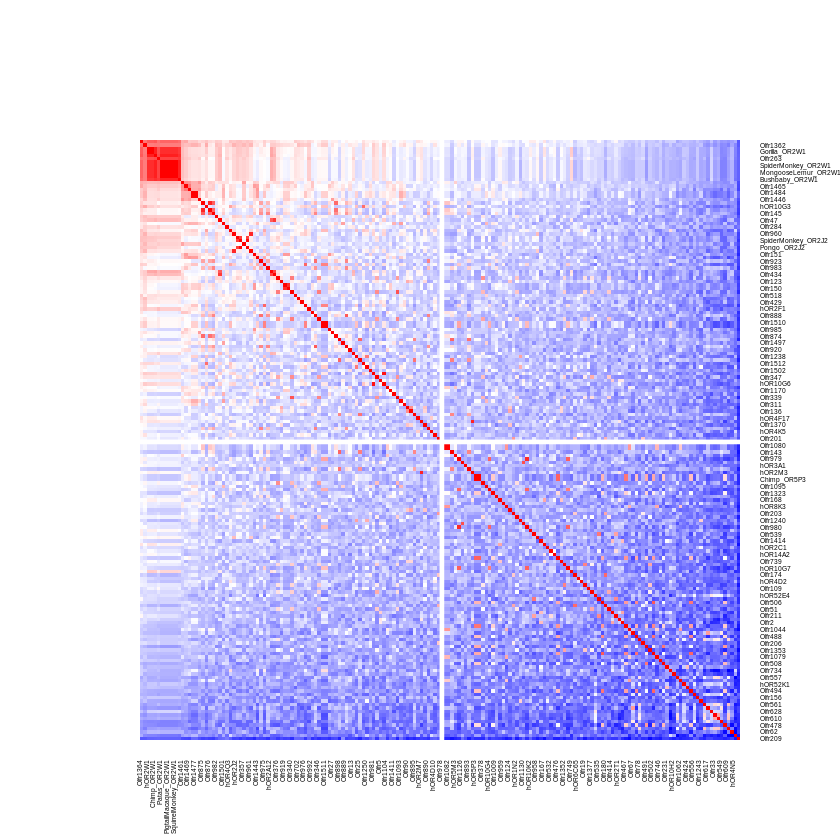

In [11]:
# creates a own color palette from red to blue
col_palette <- colorRampPalette(c("red", "white", "blue"))(n = 499)

# Define a "skewed" red-white-blue color transition
col_breaks = c(seq(0, 0.2, length = 100), # for red
               seq(0.21, 0.4, length = 100),
               seq(0.41, 0.6, length = 100),
               seq(0.61, 0.8, length = 100),
               seq(0.81, 1, length = 100)) # for blue

mapTrain <- heatmap.2(as.matrix(matTrain),       # data
                      trace = "none",            # turns off trace lines inside the heat map
                      dendrogram = "none",       # disable dendrogram
                      margins = c(5,5),          # margins around plot
                      col = col_palette,         # used the color palette defined above
                      breaks = col_breaks,       # color transition at specified breaks above
                      cexRow = 0.4,              # row label size
                      cexCol = 0.4,              # column label size
                      Colv = FALSE,              # turn off column clustering
                      Rowv = FALSE,              # turn off row clustering
                      lhei = c(1,5),             # relative heights of rows
                      lwid = c(1,5),             # relative width of columns
                      key = FALSE,               # turn off color legend
                      density.info="none",       # turn off density plot inside color legend
                      rowsep = nrow(matTrain)/2, # separate rows into 2 halves
                      colsep = ncol(matTrain)/2, # separate columns into 2 halves
                      sepwidth = c(1, 1)         # width of split line
)

#### It is a symmetric matrix. The left upper quadrant (half of the ORs) will be selected as the training set.  

In [12]:
# Seletct half the ORs using the distance cutoff 
cutoff <- median(colMeans(matTrain))
seleTrain <- matTrain[rowMeans(matTrain) < cutoff, colMeans(matTrain) < cutoff]
trainData <- trainData[colnames(seleTrain), ]

# Remove low variance features
near_zero <- nearZeroVar(trainData, freqCut = 95/5, saveMetrics = TRUE)
low_variance_cols <- near_zero[(near_zero$zeroVar == TRUE) | (near_zero$nzv == TRUE), ]
drops <- rownames(low_variance_cols)
trainData <- trainData[, !(names(trainData) %in% drops)]

trainData$Activity <- logActivity[rownames(trainData)]

cat("Selected", nrow(seleTrain), "training set ORs at the distance cutoff:", round(cutoff, 2))

# Output selected training data to file
basalTrain <- basal[basal$Gene %in% rownames(seleTrain), ]
basalTrain <- basalTrain[order(basalTrain$Mean, decreasing = TRUE), ]
write.table(basalTrain, "Basal_activity/Cross_validation/Selected_TrainingSet.tsv",
            sep = "\t", row.names = FALSE, quote = FALSE)

Selected 88 training set ORs at the distance cutoff: 0.62

## 3.2 Select test ORs within the applicability domain
### Plot the normalized distance matrix of the test set ORs vs. the training set, and select test set ORs

selected 49 test set ORs

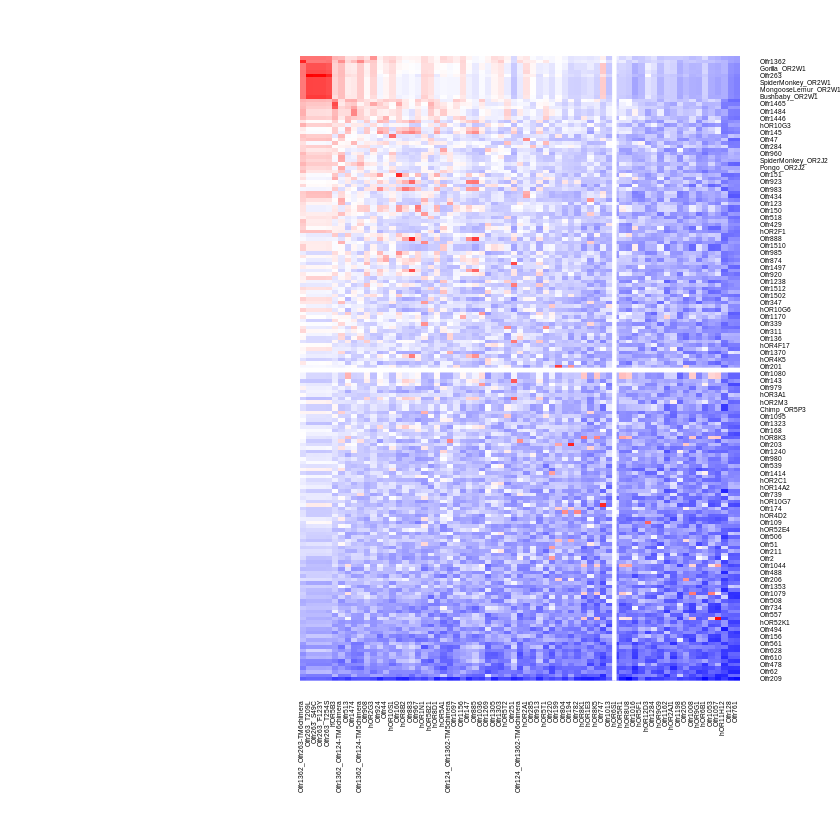

In [13]:
# Select test ORs using the same distance cutoff
seleTest <- matTest[1:nrow(seleTrain), ]
seleTest <- seleTest[, colMeans(seleTest) < cutoff]
testData <- testData[colnames(seleTest), ]

cat("selected", ncol(seleTest), "test set ORs")

mapTest <- heatmap.2(as.matrix(matTest),         # data
                      trace = "none",            # turns off trace lines inside the heat map
                      dendrogram = "none",       # disable dendrogram
                      margins = c(8,5),          # margins around plot
                      col = col_palette,         # used the color palette defined above
                      breaks = col_breaks,       # color transition at specified breaks above
                      cexRow = 0.4,              # row label size
                      cexCol = 0.4,              # column label size
                      Colv = FALSE,              # turn off column clustering
                      Rowv = FALSE,              # turn off row clustering
                      lhei = c(1,14),            # relative heights of rows
                      lwid = c(1,1.8),           # relative width of columns
                      key = FALSE,               # turn off color legend
                      density.info = "none",     # turn off density plot inside color legend
                      rowsep = ncol(seleTrain),  # separate training OR rows by the distance cutoff above
                      colsep = ncol(seleTest),   # separate test OR columns by the distance cutoff above
                      sepwidth = c(0.5, 1)       # width of split line
)

testData$Activity <- NA

## 3.3 Predict the basal activity of the selected test ORs
### Rebuild the *res68* model with the selected training ORs, then use it for prediction.

In [14]:
# Center & scale data
preProc <- preProcess(trainData, method = c("center", "scale"))
trainingProc <- predict(preProc, trainData)
testProc <- predict(preProc, testData)

# Parameter tuning using nested 5-fold cross validation
control <- trainControl(method="cv",
                        number=5,
                        summaryFunction = defaultSummary)
grid <- expand.grid(.mtry = seq(ncol(trainingProc)/2, ncol(trainingProc)-1, length.out= 5))

# Train a random forest regression model with the tuned parameters
mod_RF <- train(data = trainingProc,
                Activity ~ . , 
                trControl = control,
                method = "rf", 
                tuneGrid = grid,
                ntree = 1001,
                metric = 'Rsquared')

# Prediction on the test set
testProc$Activity <- predict(mod_RF, newdata = testProc)

## 4. Evaluate the prediction with *in vitro* data  

Model performance on in vitro test set: 


RMSE Rsquared      MAE 
    0.49     0.60     0.40

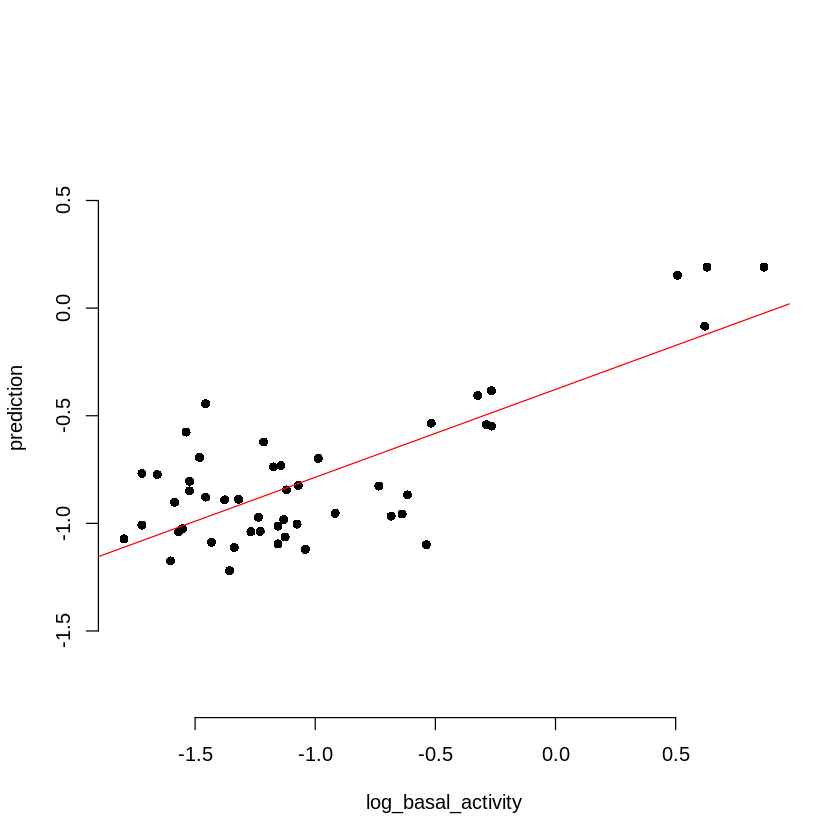

In [15]:
# Reverse the (center & scale) preprocess to recover the original scale 
reverseProc <- function(preProc, data){
  stopifnot(class(preProc) == "preProcess")
  stopifnot(class(data) == "data.frame")
  for(i in names(preProc$mean)){
    tmp <- data[, i] * preProc$std[[i]] + preProc$mean[[i]]
    data[, i] <- tmp
  }
  return(data)  
}

testPred <- reverseProc(preProc, testProc)
prediction <- testPred$Activity

# Read in vitro activity data  
basal_test <- read.csv("Basal_activity/Data/Test_set.csv")
basal_activity <- basal_test$Mean[match(rownames(testData), basal_test$Gene)]
log_basal_activity <- log10(basal_activity)

# Plot the prediction vs. in vitro values
plot(log_basal_activity, prediction, pch = 16, bty = "n", 
     xlim = range(log_basal_activity, prediction),
     ylim = range(log_basal_activity, prediction))
# Linear fit line
abline(lm(prediction ~ log_basal_activity), col=2)

# Evaluate the performance
perf <- round(postResample(prediction, log_basal_activity), 2)

cat("Model performance on in vitro test set: \n")
perf

### Output

In [16]:
summary <- cbind(basal_test[match(rownames(testPred), basal_test$Gene), ], 
                 Prediction = round(10^prediction, 3))
summary <- summary[order(summary$Mean, decreasing = TRUE), ]
summary
write.table(summary, "Basal_activity/Prediction/prediction.tsv", sep = "\t", quote = FALSE, row.names = FALSE)

,Gene,OR,Mean,SD,SEM,Replication,Prediction
1,Olfr263_T209L,MOR256-31_T209L,7.374,1.159,0.473,6,1.548
2,Olfr263_F123Y,MOR256-31_F123Y,4.271,0.887,0.361,6,1.549
3,Olfr263_S49C,MOR256-31_S49C,4.179,1.286,0.525,6,0.824
4,Olfr263_T254S,MOR256-31_T254S,3.220,0.215,0.089,6,1.421
5,Olfr1362_Olfr263-TM6chimera,MOR256-8_-31_TM6chimera,0.542,0.123,0.051,6,0.283
6,Olfr124_Olfr1362-TM5chimera,MOR256-3_-8_TM5chimera,0.541,0.089,0.051,6,0.413
7,Olfr1362_Olfr124-TM6chimera,MOR256-8_-3_TM6chimera,0.516,0.082,0.033,6,0.287
8,Olfr124_Olfr1362-TM6chimera,MOR256-3_-8_TM6chimera,0.475,0.095,0.040,6,0.393
10,Olfr1362_Olfr124-TM5chimera,MOR256-8_-3_TM5chimera,0.304,0.031,0.013,6,0.292
11,Olfr160,MOR171-3,0.290,0.036,0.021,3,0.080
